In [1]:
!pip install transformers

In [139]:
!pip install -U sagemaker

In [56]:
from sagemaker.session import Session
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()
sagemaker_session_bucket = sess.default_bucket()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

In [57]:
print(sess.default_bucket())

sagemaker-us-east-2-494725113354


In [58]:
print(aws_region)

us-east-2


In [59]:
import pandas as pd
import os
import ast

# conn = boto3.client("s3")
# s3_path = "multiclass-text-classify"
# content=conn.list_objects(Bucket=s3_path)['Contents']

# for data in content:
#     dataset=data['Key']

# print(dataset)
# df = pd.read_csv(f"s3://{s3_path}/{dataset}", on_bad_lines='skip')
# df.head(5)
df = pd.read_csv("newsCorpora.csv", sep='\t',names=['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP'])
df.head(5)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422419 entries, 0 to 422418
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID         422419 non-null  int64 
 1   TITLE      422419 non-null  object
 2   URL        422419 non-null  object
 3   PUBLISHER  422417 non-null  object
 4   CATEGORY   422419 non-null  object
 5   STORY      422419 non-null  object
 6   HOSTNAME   422419 non-null  object
 7   TIMESTAMP  422419 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 25.8+ MB


In [61]:
df1=df[['TITLE','CATEGORY']]
df1.head()

,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


In [62]:
cat={
    'e':'entertainment',
    'b':'business',
    't':'science',
    'm':'health'
}

In [63]:
def update_category(x):
    return cat[x]

In [64]:
df1['CATEGORY']=df1['CATEGORY'].apply(lambda x:update_category(x))
df1.head(5)

/tmp/ipykernel_165/1265016023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['CATEGORY']=df1['CATEGORY'].apply(lambda x:update_category(x))


,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",business
1,Fed's Charles Plosser sees high bar for change...,business
2,US open: Stocks fall after Fed official hints ...,business
3,"Fed risks falling 'behind the curve', Charles ...",business
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,business


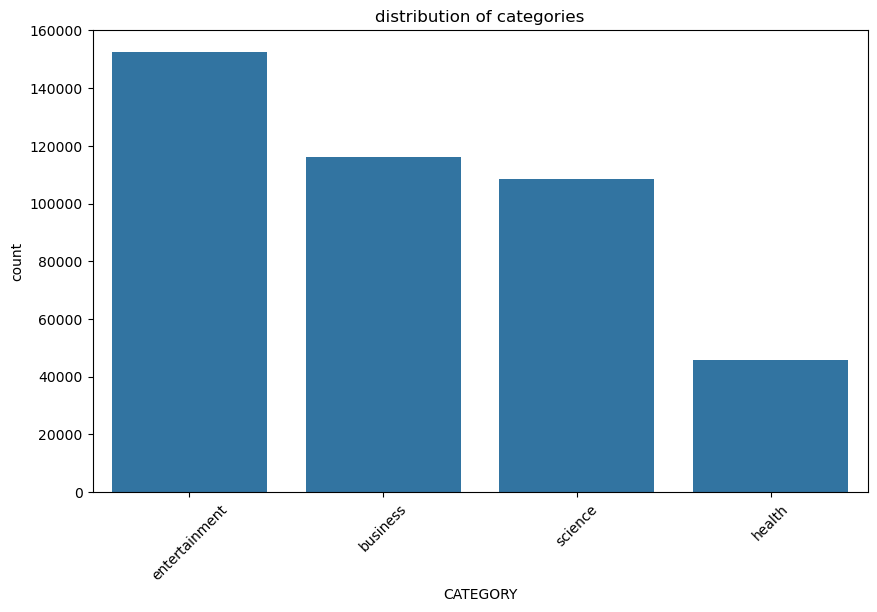

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(data=df1,x='CATEGORY',order=df1['CATEGORY'].value_counts().index)
plt.title("distribution of categories")
plt.xticks(rotation=45)
plt.show()

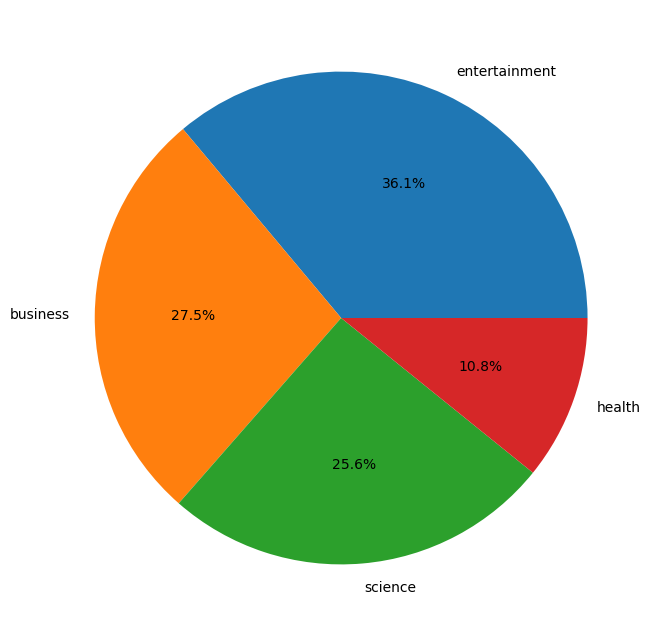

In [66]:
cat_counts=df1['CATEGORY'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(cat_counts,labels=cat_counts.index,autopct='%1.1f%%')
plt.show()

**Preprocessing dataset**

In [67]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AutoTokenizer
from tqdm import tqdm

In [68]:
df2=df1.sample(frac=0.05,random_state=1)#for testing models so, first take a fraction and then run on small data
df2=df2.reset_index(drop=True)

In [69]:
#just a fraction
df2.count()

TITLE       21121
CATEGORY    21121
dtype: int64

In [70]:
df2.head()

,TITLE,CATEGORY
0,Murdoch's bid for Time Warner rejected,business
1,Rescuers close in on 3 trapped Honduran miners...,business
2,Johnny Depp - Johnny Depp Served With Legal Pa...,entertainment
3,"Apple prepping move into ""smart home"" connecti...",science
4,Ripped First Look: Dwayne Johnson as Brett Rat...,entertainment


In [71]:
label_encode={}
def encode(x):
   if x not in label_encode.keys():
       label_encode[x]=len(label_encode)
   return label_encode[x]

In [72]:
df2['labels']=df2['CATEGORY'].apply(lambda x:encode(x))
df2.head(5)

,TITLE,CATEGORY,labels
0,Murdoch's bid for Time Warner rejected,business,0
1,Rescuers close in on 3 trapped Honduran miners...,business,0
2,Johnny Depp - Johnny Depp Served With Legal Pa...,entertainment,1
3,"Apple prepping move into ""smart home"" connecti...",science,2
4,Ripped First Look: Dwayne Johnson as Brett Rat...,entertainment,1


In [73]:
X = df2['TITLE'].tolist()
y = df2['labels'].tolist()

In [75]:
tokenizer_name='distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [76]:
# 'inputs' is now a dictionary containing 'input_ids' and 'attention_mask'
inputs=tokenizer(
    X,
    max_length=20,
    padding='max_length',
    truncation=True,
    return_tensors="pt"
)

In [77]:
# Convert labels to a tensor
labels = torch.tensor(y)

In [78]:
# Create a dataset from the tokenized inputs and labels
dataset_final = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [79]:
# Split the dataset into training and validation sets (e.g., 80/20 split)
train_size = int(0.7 * len(dataset_final))

In [80]:
val_size = len(dataset_final) - train_size
train_dataset, val_dataset = random_split(dataset_final, [train_size, val_size])

# Create DataLoaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [81]:
print(train_size)
print(val_size)

14784
6337


**Saving the preprocessed dataset into session bucket**

In [82]:
# 1. Save the model to a local temporary file
local_train_path = 'train.pth'
torch.save(train_dataloader, local_train_path)

# 2. Upload the file to S3 using boto3
s3 = boto3.client('s3')
bucket_name = sess.default_bucket()
s3_key = 'preprocessed_data/train.pth' # The path within your bucket

s3.upload_file(local_train_path, bucket_name, s3_key)

print(f"File uploaded to s3://{bucket_name}/{s3_key}")

File uploaded to s3://sagemaker-us-east-2-494725113354/preprocessed_data/train.pth


In [83]:
# 1. Save the model to a local temporary file
local_test_path = 'test.pth'
torch.save(val_dataloader, local_test_path)

# 2. Upload the file to S3 using boto3
s3 = boto3.client('s3')
bucket_name = sess.default_bucket()
s3_key = 'preprocessed_data/test.pth' # The path within your bucket

s3.upload_file(local_test_path, bucket_name, s3_key)

print(f"File uploaded to s3://{bucket_name}/{s3_key}")

File uploaded to s3://sagemaker-us-east-2-494725113354/preprocessed_data/test.pth


**Training Job**

In [84]:
aws_role

'arn:aws:iam::494725113354:role/service-role/AmazonSageMaker-ExecutionRole-20250715T153149'

In [85]:
pip show transformers

Name: transformers
Version: 4.52.4
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /opt/conda/lib/python3.12/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: amazon_sagemaker_jupyter_ai_q_developer, autogluon.multimodal, autogluon.timeseries
Note: you may need to restart the kernel to use updated packages.


In [86]:
pip show torch

Name: torch
Version: 2.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /opt/conda/lib/python3.12/site-packages
Requires: filelock, fsspec, jinja2, networkx, setuptools, sympy, typing-extensions
Required-by: accelerate, autogluon.multimodal, autogluon.timeseries, fastai, lightning, pytorch-lightning, pytorch-metric-learning, timm, torchmetrics, torchvision
Note: you may need to restart the kernel to use updated packages.


In [87]:
pip --version

pip 25.1.1 from /opt/conda/lib/python3.12/site-packages/pip (python 3.12)
Note: you may need to restart the kernel to use updated packages.


In [143]:
from sagemaker.huggingface import HuggingFace,HuggingFaceModel

In [150]:

# ml.g4dn.xlarge,ml.p3.2xlarge
hf_estimator=HuggingFace(
    entry_point='train.py',#have information about model arch, training job, loss function
    source_dir='./',
    role=aws_role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    transformers_version='4.49.0',
    pytorch_version='2.5.1',
    output_path=f's3://{sess.default_bucket()}/text_classify_model',
    py_version='py311',
    hyperparameters={'epochs':3,
                     'train_batch_size':4,
                     'valid_batch_size':2,
                     'learning_rate':1e-05
                    },
    enable_sagemaker_metrics=True
)

In [151]:
#runs the training job as stated above
hf_estimator.fit({
    'train': f's3://{sess.default_bucket()}/preprocessed_data/', 
    'test': f's3://{sess.default_bucket()}/preprocessed_data/'
})

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-pytorch-training-2025-07-17-00-13-30-592


2025-07-17 00:15:51 Starting - Starting the training job...
2025-07-17 00:16:05 Starting - Preparing the instances for training...
2025-07-17 00:16:30 Downloading - Downloading input data...
2025-07-17 00:17:01 Downloading - Downloading the training image...........................
2025-07-17 00:21:33 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
CUDA compat package should be installed for NVIDIA driver smaller than 550.144.03
Current installed NVIDIA driver version is 550.163.01
Skipping CUDA compat setup as newer NVIDIA driver is installed
2025-07-17 00:21:44,348 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-07-17 00:21:44,368 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-07-17 00:21:44,377 sagemaker_pytorch_container.training INFO     Block until all host

In [152]:
model_s3_path = f"s3://{sess.default_bucket()}/text_classify_model/huggingface-pytorch-training-2025-07-17-00-13-30-592/output/model.tar.gz"

# --- 2. Create a HuggingFaceModel object ---
# This object points to your existing model artifacts instead of a training script.
# Ensure the framework versions match what you used for training.
huggingface_model = HuggingFaceModel(
    model_data=model_s3_path,      # Path to your trained model
    role=aws_role,                     # Your SageMaker execution role
    transformers_version="4.49.0", # Use a supported version you trained with
    pytorch_version="2.6.0",       # Use the PyTorch version you trained with
    py_version="py312"             # Use the Python version you trained with
)

# --- 3. Deploy the model to an endpoint ---
# This will create a real-time inference endpoint.
print("Deploying the model to a SageMaker endpoint...")
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge"  # You can use a CPU instance for inference
)

Deploying the model to a SageMaker endpoint...


INFO:sagemaker:Creating model with name: huggingface-pytorch-inference-2025-07-17-00-27-24-439
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-inference-2025-07-17-00-27-25-005
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-inference-2025-07-17-00-27-25-005


------!

In [153]:
print(f"Endpoint '{predictor.endpoint_name}' created successfully.")

Endpoint 'huggingface-pytorch-inference-2025-07-17-00-27-25-005' created successfully.


In [154]:
predictor.predict({
	"inputs": "I am going to get married soon, its going to be awesome",
})

[{'label': 'LABEL_1', 'score': 0.9491696953773499}]